# USD MADS Capstone Project - Team 14

## Predicting Cell Culture Viability using a Sequential Hybrid Model

_______

**Team Members**  



Hanmaro Song  
hanmarosong@sandiego.edu  

Emanuel Lucban  
elucban@sandiego.edu

_____

# Introduction

Computer vision is an interdisciplinary field that enables computer systems the ability to generate insights from an environment through use of digital visual inputs. Computer vision systems have become ubiquitous, applied to complex problems such as facial recognition and automated driving (Hiramatsu et al., 2018). Recently, medicine has become another field where computer vision is successfully being applied. Image segmentation is being used in radiology to identify tumors from MRI images, quickly outpacing the capabilities of human experts. Computer vision can also be applied to research involving cell biology. 

Experimentation involving cell cultures is a very time consuming, laborious process that requires a controlled environment and monitoring. A single cell culture experiment can take hours or weeks to run. Unforeseen errors that occur during the preparation of an experiment can affect the viability of a cell culture, potentially invalidating the results, costing time and effort. We propose the use of convolutional neural networks (CNNs) to learn salient features from the visible structures formed by cultured cells to provide early prediction of the cell culture’s viability.

# Background  

For our research use-case, the women’s reproductive health study led by Dr. Leo Han at The Oregon Health and Sciences University (OHSU) is conducting a study to develop a hormoneless contraceptives protocol. The study uses harvested endometrial cells from several primates and cultured in small vessels known as wells. For each test run, a group of wells is given a precisely controlled number of endometrial cells. Certain wells are then treated with different drugs and doses, recorded using photography at fixed intervals of 0 hours, 12 hours, 24 hours, 48 hours, 72 hours, and 96 hours. 

<img src="plots/Run.png" alt="A Run Cells" width="800" height="500"/>

Mucus formation along the exterior wall is formed, known as the meniscus. The amount of meniscus produced is directly correlated with a woman’s receptiveness to pregnancy. The correct combination of drugs and doses that affect meniscus production can potentially be used as an effective contraceptive protocol, without the side effects associated with hormone-based contraceptive methods.

# Problem

A significant issue was discovered in the course of the OHSU research study. In almost every run, large variability in results occurs at the 96-hour interval. 
Wells that have been treated exactly the same, (same number of cells, treatment and time) can produce dramatically different results as shown in the following picture.

<img src="plots/Process.png" alt="Cells over time" width="500" height="300"/>


The well with abnormal results must then be discarded, potentially wasting 96 hours of an experiment run.
Our motivation is to conduct a project that involves solving a highly complex problem utilizing computer vision. 
Our hope for this project is to leverage deep convolutional models to streamline the process of identifying viable wells and predict whether a well should be rejected early in a run. 
This will not only save time for the research study but will also potentially remove human error associated with manual checking of wells that are out of range. 

As an example in the next chart, we can see that there is no visible or clear distinction between those cells marked as **OMIT**(Left) and **KEEP**(Right).

<img src="plots/Comparison.png" alt="Comparison" width="300" height="500"/>

When researchers were conducting experiments, they didn't put much focus on the structures of cells but rather the combinations of drugs as they are the main sources affecting the outcome.
However, after seeing many occasions where same amount of drugs with the same combinations gave different outputs, they suspected that maybe the structure of each cell affects the results as well which we are trying to explore in this project.

## Python Libraries

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import json
import random

import cv2
from PIL import Image

# import tensorflow as tf
import torch
import torch.nn as nn
# pretrained resnet
from torchvision.models import resnet50, ResNet50_Weights


# Preprocessing for modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics, linear_model, tree

# Classic ML Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

_______

# Exploratory Data Analysis and Preprocessing

**This is a condensed demonstration of the preprocessing tasks. For the full code, see the notebooks in the [Processing Notebooks](https://github.com/hsong1101/HTS_Imaging_Project/tree/master/Processing%20Notebooks) folder.**

Because the main objects in this problem is images, most of the preprocessing and EDA are done for this. There are some tabulated data which contain only the basic metadata such length of the meniscus length, and some other scientific measurements done by researchers and their medical equipments.

### Images

Each experimentation consists of total of 96 cells (8 rows and 12 columns) shown as below.

<img src='plots/Run.png' width='800'>

Each run has six different stages: Baseline where each cell is in its original form without any drugs applied on them, 0 hr (right after applying drugs), 24hr, 48hr, 72hr, and 96hr.

<img src='plots/Process.png' width='800'>

But for the purpose of our project, we will be using 0hr images so that once they apply the drugs and find any cells that a machine learning model predicts as invalid, it will be thrown out and be replaced to save time.

The general process of the extraction is as follows.

1. Original
2. Grayscale
3. Invert grayscale
4. Extract areas of interest using threshold 
5. Extract contours of areas
6. Filter out any bounding boxes that are either too big, too small, or don't make sense.
7. Get the final wall image
8. Reshape the image by 448 by 448

![Extraction Process](plots/Extraction.png)

In [54]:
import sys
# utils is from a sub directory
sys.path.append('Processing Notebooks')

from utils import *
import matplotlib.pyplot as plt
import cv2

In [55]:
image = cv2.imread('data/zero_hour_images/Run11_0Hr_XY29_00001_CH4.tif')

The original example image

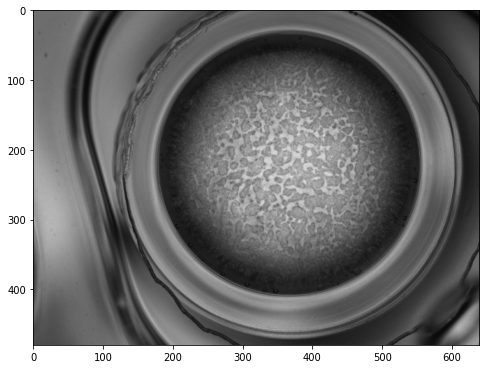

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(image);

This is the function that processes the extracted cell. Or the notebook for detailed list of process is [here](https://github.com/hsong1101/HTS_Imaging_Project/blob/master/Processing%20Notebooks/Preprocessing_0_Image.ipynb)

In [61]:
def show_processed_image(img, show_plot=True):
    
    # This converts an image into gray, inverted gray, and gets a list of contours
    gray, inv_gray, thresh, contoured, contours = get_contours(img)

    # Cleaning contours and dropping unnecessary ones
    contours = clean_contours(contours)
    
    centroids = get_centroids(img, contours)

    # Extract one final well
    final_image, ring = get_final_wall(img, contours)
    
    # Extract the cell
    extracted_image = extract_cell(gray, ring)
    
    if show_plot:
        fig, ax = plt.subplots(1, 8, figsize=(24, 8))
        
        ax[0].imshow(img)
        ax[0].set_title('Original Image')

        ax[1].imshow(gray, cmap='gray')
        ax[1].set_title('Grayscale Image')

        ax[2].imshow(inv_gray, cmap='gray')
        ax[2].set_title('Inverted Grayscale Image')

        ax[3].imshow(thresh)
        ax[3].set_title('Extracted Area Image')

        ax[4].imshow(contoured)
        ax[4].set_title('Contours of Image')

        ax[5].imshow(centroids)
        ax[5].set_title('Centroids of Contours')

        ax[6].imshow(final_image)
        ax[6].set_title('Final Cell Image')

        ax[7].imshow(extracted_image, cmap='gray')
        ax[7].set_title('Extracted Wall')
    
    return extracted_image

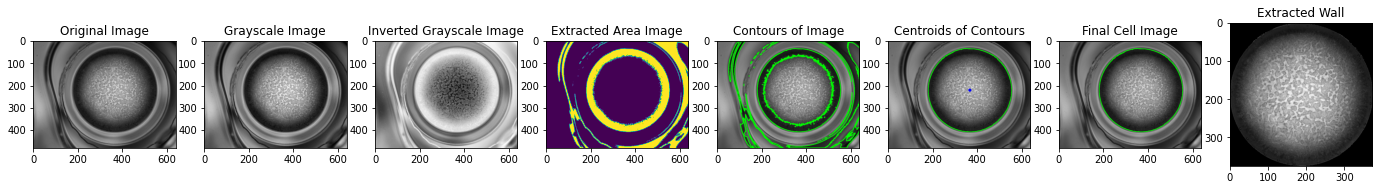

In [60]:
_ = show_processed_image(image)

Though most of the images were successfully processed, there are some outliers shown as below.

![](plots/Outliers.png)

To address this issue, using histogram on darkness and brightness, we dropped any anomalies. This can be found [here](https://github.com/hsong1101/HTS_Imaging_Project/blob/master/Processing%20Notebooks/Preprocessing_1_Image.ipynb) for detailed view.

After implementing the fuction, this is the result below that have been successfully and randomly displayed

![](plots/Extracted_Cells.png)

After all the process, one main issue that arose is the lack of number of training data. To fix this, we had to augment these images by randomly flipping or rotating. This can be found [here](https://github.com/hsong1101/HTS_Imaging_Project/blob/master/Processing%20Notebooks/Preprocessing_3_data_augmentation.ipynb)

### Tabulated Data

In [62]:
merged = pd.read_csv('data/merged.csv')

In [67]:
merged.head(10)

,IMAGE_ID,SUGGEST_OMIT,CIRCULARITY_VALUE,REGRESSION_R2,EC50Y,OMIT_CALL,GROUP_ID,MEASURE_T0_BASE_VALUE,MEASURE_MAG_VALUE,MENISCUS_LENGTH,...,DRUG_DRY,DRUG_CONTROL,DRUG_MISSING,DRUG_BUMETANIDE,DRUG_E2,DRUG_GLYH101,DRUG_INH172,DRUG_MANNITOL,DRUG_P4,DRUG_PBS
0,data/extracted/Run15_0Hr_XY01_00001_CH4.png,Possible poor detection of inflection / menisc...,OK,0.999429,20343.270855,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,400uM,100nM,1uM,10uM,300mM,1uM,8uL
1,data/extracted/Run15_0Hr_XY02_00001_CH4.png,OK: fit 0.909665,OK,0.999262,32229.751964,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
2,data/extracted/Run15_0Hr_XY05_00001_CH4.png,OK: fit 0.935102,OK,0.999214,26054.752969,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,1nM,0,0,0,0,0
3,data/extracted/Run15_0Hr_XY06_00001_CH4.png,OK: fit 0.975717,OK,0.999291,20132.237483,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
4,data/extracted/Run15_0Hr_XY07_00001_CH4.png,OK: fit 0.240573,OK,0.998862,24441.022005,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
5,data/extracted/Run15_0Hr_XY08_00001_CH4.png,OK: fit 0.929277,Standards_Used_0.6872,0.999592,21503.259508,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
6,data/extracted/Run15_0Hr_XY09_00001_CH4.png,OK: fit 0.925615,OK,0.999605,25616.974622,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
7,data/extracted/Run15_0Hr_XY11_00001_CH4.png,OK: fit 0.953494,OK,0.999671,29723.922949,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
8,data/extracted/Run15_0Hr_XY12_00001_CH4.png,OK: fit 0.941422,OK,0.999449,29501.085200,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
9,data/extracted/Run15_0Hr_XY13_00001_CH4.png,OK: fit 0.929587,OK,0.999694,32296.468149,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0


As shown above, many are either missing data or it is not necessary such as SUGGEST_OMIT which we don't really use and is for researchers mainly. Also for drugs data, we had to drop this because we don't really care about the combinations of drugs as there are cases where the same combinations still ended up in different results.

These are the features from the tabulated data that we decided to keep.

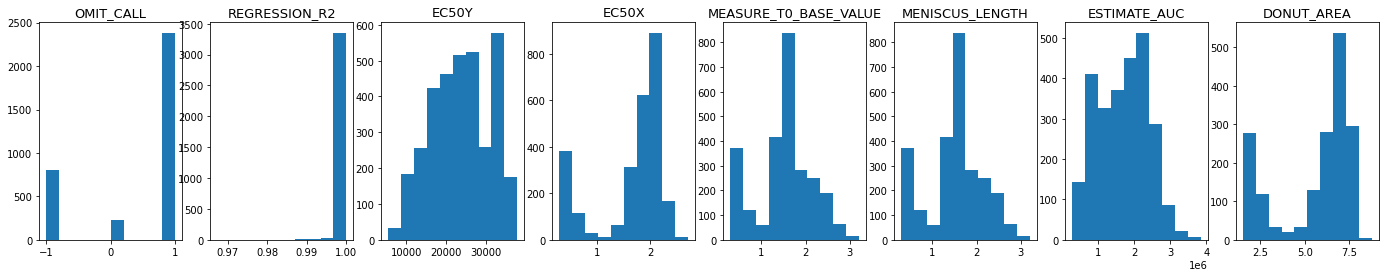

In [64]:
num_cols = [	
    'OMIT_CALL',
    'REGRESSION_R2',
    'EC50Y',
    'EC50X',
    'MEASURE_T0_BASE_VALUE',
    'MENISCUS_LENGTH',
    'ESTIMATE_AUC',
    'DONUT_AREA',
   ]

fig, ax = plt.subplots(1, len(num_cols), figsize=(24, 4))

for i, c in enumerate(num_cols):
    ax[i].hist(merged[c])
    ax[i].set_title(c, fontsize=13)

_________



# Modeling Methodology: Sequential Hybrid Model

Our approach to modeling consists of the use of two models in sequence. First, a pretrained CNN model trained on large image datasets to perform feature extraction. Second, a classification model that will take the extracted features from the CNN as input and trained on the OMIT labels from the HTS tabular dataset. This sequential hybrid model approach is similar to a technique known as transfer learning.

## Modeling: RESNET50 Feature Extractor
The pretrained RESNET50 will then be modified to extract output from the last convolutional block before the fully connected (FC) layers. Essentially, we will be bypassing the classification layers in RESNET50 and extracting the encoded image input features at the last convolutional layer, also known as the deep residual features. The deep residual features creates an embedding of the input image as a 2,048 length vector representation. That representation can then be used as features to train an subsequent classification model.


In [5]:
ext_path = os.path.join('data', 'extracted')
save_path = os.path.join('data', 'augmentation')

# Set Random Seed at 42
random.seed(42)

In [25]:
# initialize pretrained resnet
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
# Get all hidden layers before softmax, this will be the pretrained encoder generating the embeddings
modules = list(resnet.children())[:-1]
encoder = nn.Sequential(*modules)

# Freezing parameters is mainly used in direct transfer learning and might not apply here
for param in encoder.parameters():
    # Freeze parameters so gradient is not computed in backward()
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py
    param.requires_grad = False

As a demonstration of generating an embedding from a sample image. To see the full code used to preprocess the embeddings from the entire dataset, see [Modeling_0_Transfer_Learning.ipynb](https://github.com/hsong1101/HTS_Imaging_Project/blob/master/Modeling%20Notebooks/Modeling_0_Transfer_Learning.ipynb) in the Modeling Notebooks folder

In [26]:
# Test Image
test = cv2.imread('data/extracted/Run11_0Hr_XY02_00001_CH4.png')
im_pil = Image.fromarray(test)

# Setting to evaluation mode
encoder.eval()

# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

# Apply it to the input image
img_transformed = preprocess(im_pil)

emb = encoder(img_transformed.unsqueeze(0))

### Example of 2,048 length vector embedding of test image

In [27]:
# The resulting 2,048 vector embedding from the input image
emb[0].flatten()

tensor([0.0126, 0.0000, 0.1524,  ..., 0.0106, 0.0000, 0.0141])

## Modeling: Classification Model
After creating embeddings using the RESNET50 model, various machine learning classification models are then selected for training and evaluation. These classification models included linear classifiers such as Logistic Regression and Support Vector Machines (SVM). Generative models were also considered, such as Gaussian Discriminant Analysis like Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA), and naïve Bayes. Trees and ensemble models such Decision Trees, Random Forests (RFC) and Extreme Gradient Boosting Machines (XGBoost) were also tested. Hyperparameter tuning for each model was performed using a grid search based on training and validation set accuracy.


To see all the modeling training and hyperparameter tuning see the [Modeling_1_Classification.ipynb](https://github.com/hsong1101/HTS_Imaging_Project/blob/master/Modeling%20Notebooks/Modeling_1_Classification.ipynb) notebook in the Modeling Notebooks folder

In [10]:
# Loading dataset and creating train/test split and oversampling using SMOTE
ml_df = pd.read_csv('data/ML_Dataset.csv')
X_train, X_test, y_train, y_test = train_test_split(ml_df.drop(columns=['OMIT_CALL']), 
                                                    ml_df['OMIT_CALL'], 
                                                    test_size=0.20, 
                                                    random_state=42)
sm = SMOTE(sampling_strategy='not majority', random_state=42, n_jobs=4)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [11]:
# Collect Metrics
all_metrics = pd.DataFrame()

### Best Model: Support Vector Machines

In [12]:
# Best hyperparameters
svm = SVC(C=50, kernel='rbf', gamma = 'auto', random_state=42, probability=True)
svm.fit(X_train, y_train)
svm_pred_test = svm.predict_proba(X_test)

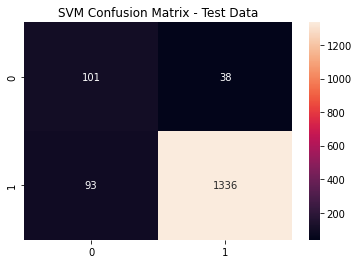

In [15]:
# Predicted Classes
svm_pred = (svm_pred_test[:, 1] >= 0.5).astype(int)

metrics.accuracy_score(y_test, svm_pred)
svm_cfm = metrics.confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cfm, annot=True, fmt='d')
plt.title('SVM Confusion Matrix - Test Data')
plt.show()

In [16]:
# Get metrics
svm_met = pd.DataFrame(metrics.classification_report(y_test, svm_pred, 
                                                     output_dict=True)).transpose()
svm_met['model'] = 'SVM'
all_metrics = pd.concat([all_metrics, svm_met.reset_index()], axis=0)
svm_met

,precision,recall,f1-score,support,model
0,0.520619,0.726619,0.606607,139.000000,SVM
1,0.972344,0.934920,0.953264,1429.000000,SVM
accuracy,0.916454,0.916454,0.916454,0.916454,SVM
macro avg,0.746481,0.830769,0.779935,1568.000000,SVM
weighted avg,0.932299,0.916454,0.922534,1568.000000,SVM


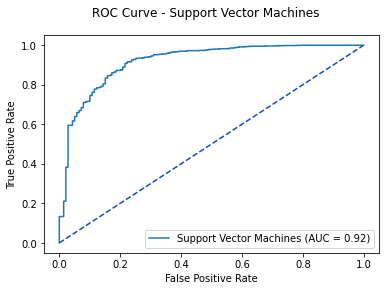

In [17]:
# ROC AUC Curve
svm_roc = metrics.roc_curve(y_test, svm_pred_test[:, 1])
svm_auc = metrics.auc(svm_roc[0], svm_roc[1])
svm_plot = metrics.RocCurveDisplay(fpr=svm_roc[0], tpr=svm_roc[1], 
                                   roc_auc=svm_auc, estimator_name='Support Vector Machines')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Support Vector Machines')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
svm_plot.plot(ax)
plt.show()

### Worst Model: Naive Bayes

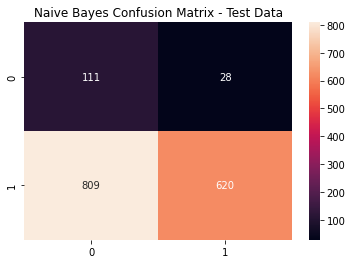

In [19]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)
nb_pred_test = nb_model.predict_proba(X_test)

# Class predictions
nb_pred = (nb_pred_test[:, 1] >= 0.5).astype('int')

# Confusion Matrix
metrics.accuracy_score(y_test, nb_pred)
nb_cfm = metrics.confusion_matrix(y_test, nb_pred)
sns.heatmap(nb_cfm, annot=True, fmt='d')
plt.title('Naive Bayes Confusion Matrix - Test Data')
plt.show()

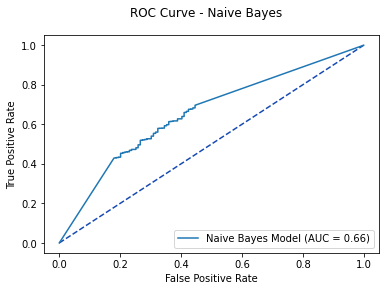

In [20]:
nb_roc = metrics.roc_curve(y_test, nb_pred_test[:, 1])
nb_auc = metrics.auc(nb_roc[0], nb_roc[1])
nb_plot = metrics.RocCurveDisplay(fpr=nb_roc[0], tpr=nb_roc[1], 
                                  roc_auc=nb_auc, estimator_name='Naive Bayes Model')

fig, ax = plt.subplots()
fig.suptitle('ROC Curve - Naive Bayes')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
nb_plot.plot(ax)
plt.show()

In [22]:
nb_met = pd.DataFrame(metrics.classification_report(y_test, nb_pred, 
                                                     output_dict=True)).transpose()
nb_met['model'] = 'Naive Bayes'
all_metrics = pd.concat([all_metrics, nb_met.reset_index()], axis=0)
nb_met

,precision,recall,f1-score,support,model
0,0.120652,0.798561,0.209632,139.000000,Naive Bayes
1,0.956790,0.433870,0.597015,1429.000000,Naive Bayes
accuracy,0.466199,0.466199,0.466199,0.466199,Naive Bayes
macro avg,0.538721,0.616215,0.403323,1568.000000,Naive Bayes
weighted avg,0.882668,0.466199,0.562674,1568.000000,Naive Bayes


## Modeling Results

Based on the accuracy and f1-score metrics, SVM outperformed all candidate models with an overall 92% accuracy and 61% f1-score for the negative class. The confusion matrix also shows SVM to have a true negative rate of 73% and a true positive rate of 93%.

RESNET50 with Naive Bayes on the other hand, resulted in the worst performance with an overall accuracy of 47% and f1-score of 21% for the negative class.

In [24]:
all_metrics.set_index(['model', 'index'])

precision    recall  f1-score      support
model       index                                                   
SVM         0              0.520619  0.726619  0.606607   139.000000
            1              0.972344  0.934920  0.953264  1429.000000
            accuracy       0.916454  0.916454  0.916454     0.916454
            macro avg      0.746481  0.830769  0.779935  1568.000000
            weighted avg   0.932299  0.916454  0.922534  1568.000000
Naive Bayes 0              0.120652  0.798561  0.209632   139.000000
            1              0.956790  0.433870  0.597015  1429.000000
            accuracy       0.466199  0.466199  0.466199     0.466199
            macro avg      0.538721  0.616215  0.403323  1568.000000
            weighted avg   0.882668  0.466199  0.562674  1568.000000

_________


# Conclusions

Despite the limitations imposed by the small dataset size, large class imbalance and time constraints, the proposed SVM classification model using RESNET50 as a feature extractor, demonstrated a measurable ability to properly classify nonviable cell cultures from 0 hour. Salient features were able to be extracted from cell culture images using RESNET50 despite being pretrained on image data unrelated to cell biology. This also demonstrates the existence of visible structures in the cell culture wells that contribute to its viability, necessitating further research into model interpretability and allowing researchers to identify the underlying cause.

________

# Next Steps

In the course of this project, certain considerations were taken into account to overcome challenges and generate results. Some of these deficiencies can be addressed with additional time and resources to potentially improve results or correct issues.

### Increased data samples  
The main issue encountered in this project was the limited number of viable image samples. Data augmentation techniques managed to triple the number of training samples; however a total of 7,836 images is not enough to train a CNN model on the domain for its intended use case, hence a sequential hybrid modeling approach was employed. Data augmentation through random sample transformations may possibly introduce unintended bias, affecting our results.

### Testing Other Convolutional Models
Due to time constraints on this project, only RESNET50 was considered for feature extraction. However there are many large and small pretrained CNN models available. This includes variants of RESNET such as RESNET 101 and 152. Other CNN models to consider are U-NET transformer and You Only Look Once (YOLO) models.

### Pretraining
Another consideration that requires additional research is the dataset the pretrained model was trained on. In this use case, RESNET50 was trained on the IMAGENET1K_V2 dataset which includes 1.2 million images across 1000 different classes designed for object detection. Potentially using a pretrained model using a dataset more closely related to cell biology may potentially improve results.  

### Model Interpretability
One of the difficulties of employing CNN models is the model’s “black-box” nature. For the intents and purposes of this project, it would be ideal to understand the underlying causes that make a cell culture nonviable along with the predictions. Further research is required to understand the nonlinear relationships between the feature maps and activations in the CNN to determine the most salient features that determine viability.

_______

# References
Allaoui, M., Kherfi, M. L., & Cheriet, A. (2020, June). Considerably improving clustering algorithms using UMAP dimensionality reduction technique: A comparative study. In A. El Moataz, D. Mammass, A. Mansouri, & F. Nouboud (Eds.) International Conference on Image and Signal Processing (pp. 317–325). Springer.

Din, N. U., & Yu, J. (2021). Training a deep learning model for single-cell segmentation without manual annotation. Scientific Reports, 11(1), 1–10. https://doi.org/10.1038/s41598-021-03299-4 

Dosovitskiy, A., Springenberg, J. T., Riedmiller, M., & Brox, T. (2014). Discriminative unsupervised feature learning with convolutional neural networks. Proceedings of the 27th International Conference on Neural Information Processing Systems - Volume 1, 766–774. Παρουσιάστηκε στο Montreal, Canada. MIT Press.

Hiramatsu, Y., Hotta, K., Imanishi, A., Matsuda, M., & Terai, K. (2018). Cell image segmentation by integrating multiple CNNs [Conference paper]. Computer Vision and Pattern Recognition, Salt Lake City, UT. https://doi.org/10.1109/CVPRW.2018.00296 

Mahmood, A., Ospina, A. G., Bennamoun, M., An, S., Sohel, F., Boussaid, F., Hovey, R., Fisher, R. B., & Kendrick, G. A. (2020). Automatic hierarchical classification of kelps using deep residual features. Sensors, 20(2), 447. https://doi.org/10.3390/s20020447 

Raghu, M., Zhang, C., Brain, G., Kleinberg, J., & Bengio, S. (2019). Transfusion: Understanding transfer learning for medical imaging [Conference paper]. 33rd Conference on Neural Information Processing Systems, Vancouver, BC. https://doi.org/10.48550/arXiv.1902.07208

Sofaer, H. R., Hoeting, J. A., & Jarnevich, C. S. (2019). The area under the precision‐recall curve as a performance metric for rare binary events. Methods in Ecology and Evolution, 10(4), 565–577.

Vocaturo, E., Zumpano, E., & Veltri, P. (2018, December). Image pre-processing in computer vision systems for melanoma detection. In 2018 IEEE International Conference on Bioinformatics and Biomedicine (BIBM) (pp. 2117-2124). IEEE.

Zhang, Q., Wu, Y., & Zhu, S. (2018). Interpretable convolutional neural networks [Conference paper]. Computer Vision and Pattern Recognition, Salt Lake City, UT. https://openaccess.thecvf.com/content_cvpr_2018/html/Zhang_Interpretable_Convolutional_Neural_CVPR_2018_paper.html 
